# ZEMAX Rayfile Generation
---
### IQA
Far field focal length lens = 80mm

Near field magnification = 1

['100dc.txt', 'FF CW Full Module_0001.ascii.csv', 'NF CW Full Module_0001.ascii.csv']


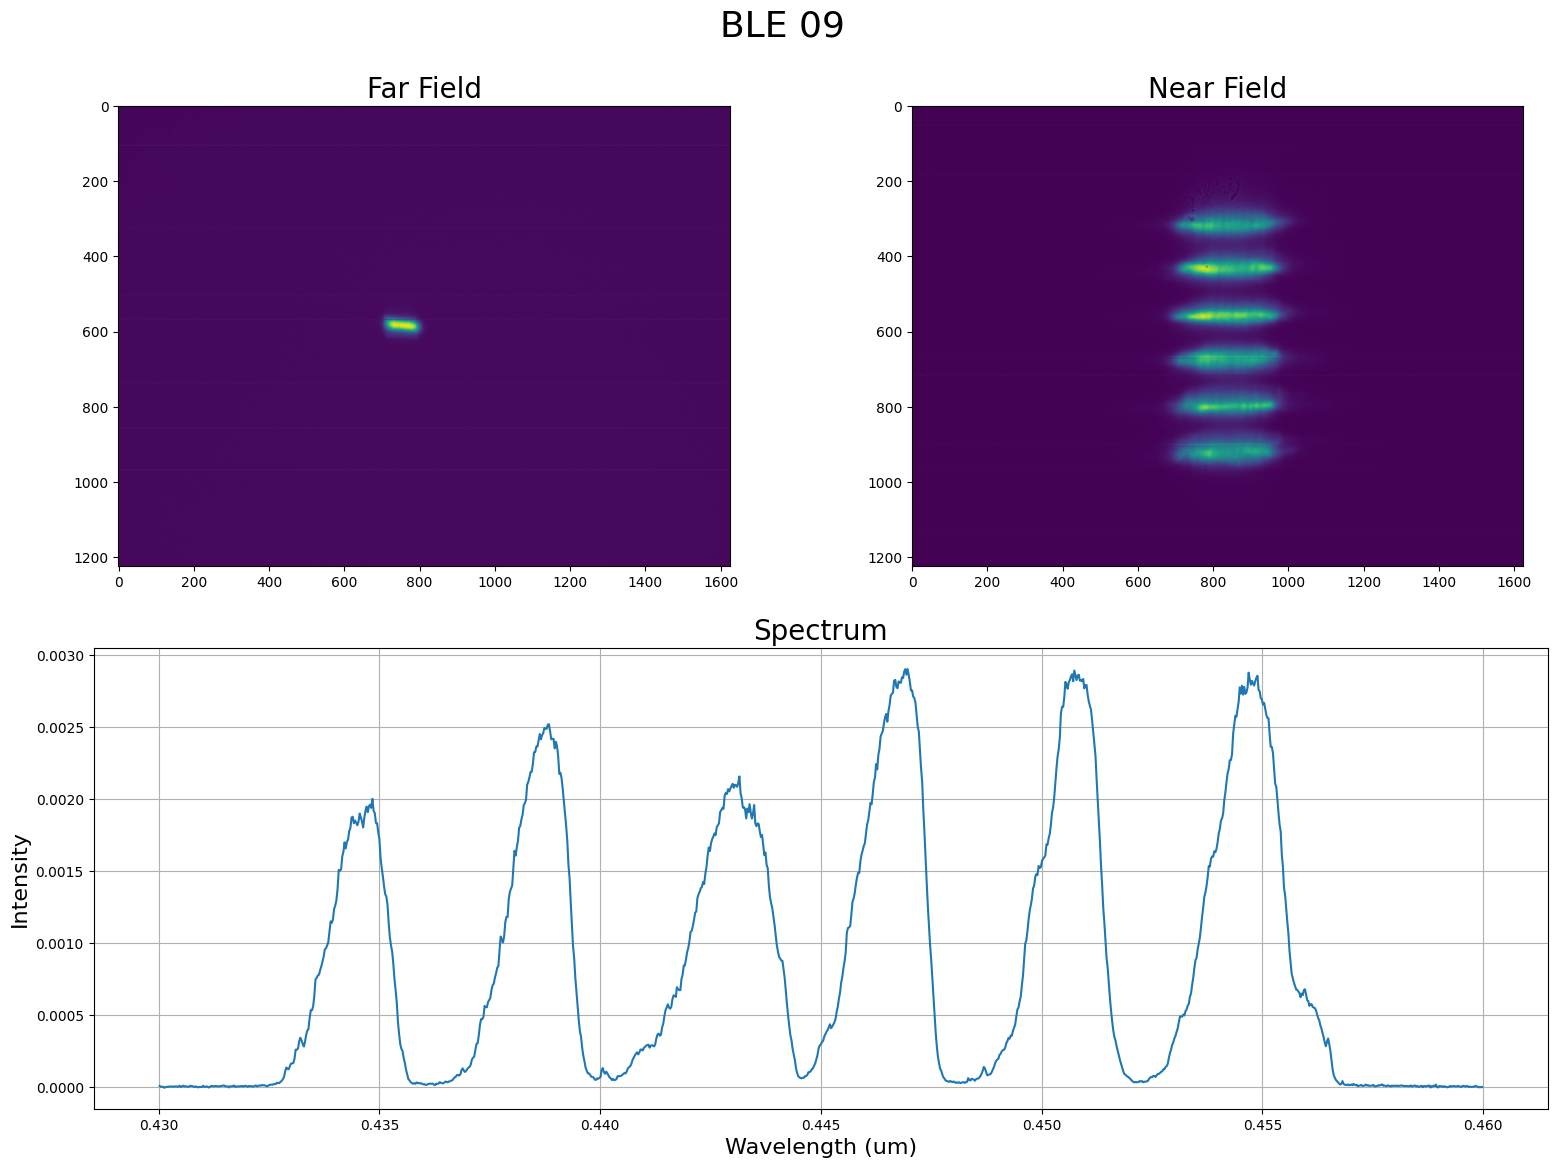

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
# sys.path.append('../') # Needed for import
import laserbeamtools as lbt

# Plot title
title = 'BLE 09'

# Create a list of the files
folder = r'../tests/test_beam_profiles/For_Rayfile_Gen/09'
print(os.listdir(folder))

# Far field images
ff1_file = '/'.join([folder,r'FF CW Full Module_0001.ascii.csv'])
ff1 = lbt.load_img(ff1_file)
ff = ff1/np.sum(ff1)

# Near field images
nf1_file = '/'.join([folder,r'NF CW Full Module_0001.ascii.csv'])
nf1 = lbt.load_img(nf1_file)
nf = nf1/np.sum(nf1)

# Spectrum
spectrum_file = '/'.join([folder, r'100dc.txt'])

# generate lists
spectrum = lbt.open_spectrum(spectrum_file)
spec_x = spectrum[0]
spec_y = spectrum[1]

# Trim spectrum file
indexs = (spec_x < 460) & (spec_x > 430)
spec_x_t = spec_x[indexs]/1000
spec_y_t = spec_y[indexs]
spectrum_t = [spec_x_t, spec_y_t]

# Plot data
fig = plt.figure(figsize=(16,12))

gs0 = gridspec.GridSpec(2, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0])
ax1.imshow(ff)
ax1.set_title('Far Field', fontsize=20)

ax2 = fig.add_subplot(gs00[1])
ax2.imshow(nf)
ax2.set_title('Near Field', fontsize=20)

ax3 = fig.add_subplot(gs0[1])
ax3.plot(spec_x_t, spec_y_t)
ax3.grid('on')
ax3.set_title('Spectrum', fontsize=20)
ax3.set_xlabel('Wavelength (um)', fontsize = 16)
ax3.set_ylabel('Intensity', fontsize = 16)

plt.suptitle(title, fontsize = 26)
fig.tight_layout(pad=2)

plt.show()

# Crop And Center The Far Field Image
---
Run `beam_size()` to determine beam parameters.

Run `subtract_corner_background()` with `iso_noise=False` to subtract the background and zero all pixels below a certain threshold.

Run `crop_image_to_integration_rect()` to reduce the size of the image.

Must also verify that `beam_size()` found the correct parameters, this can be easily done by looking at the output of `plot_image_analysis()`.

`ff_c` is our new far field array. 

The center of the beam ellipse is at (430, 340)
The ellipse diameter (closest to horizontal) is 116 pixels
The ellipse diameter (closest to   vertical) is 64 pixels
The ellipse is rotated -6° ccw from the horizontal


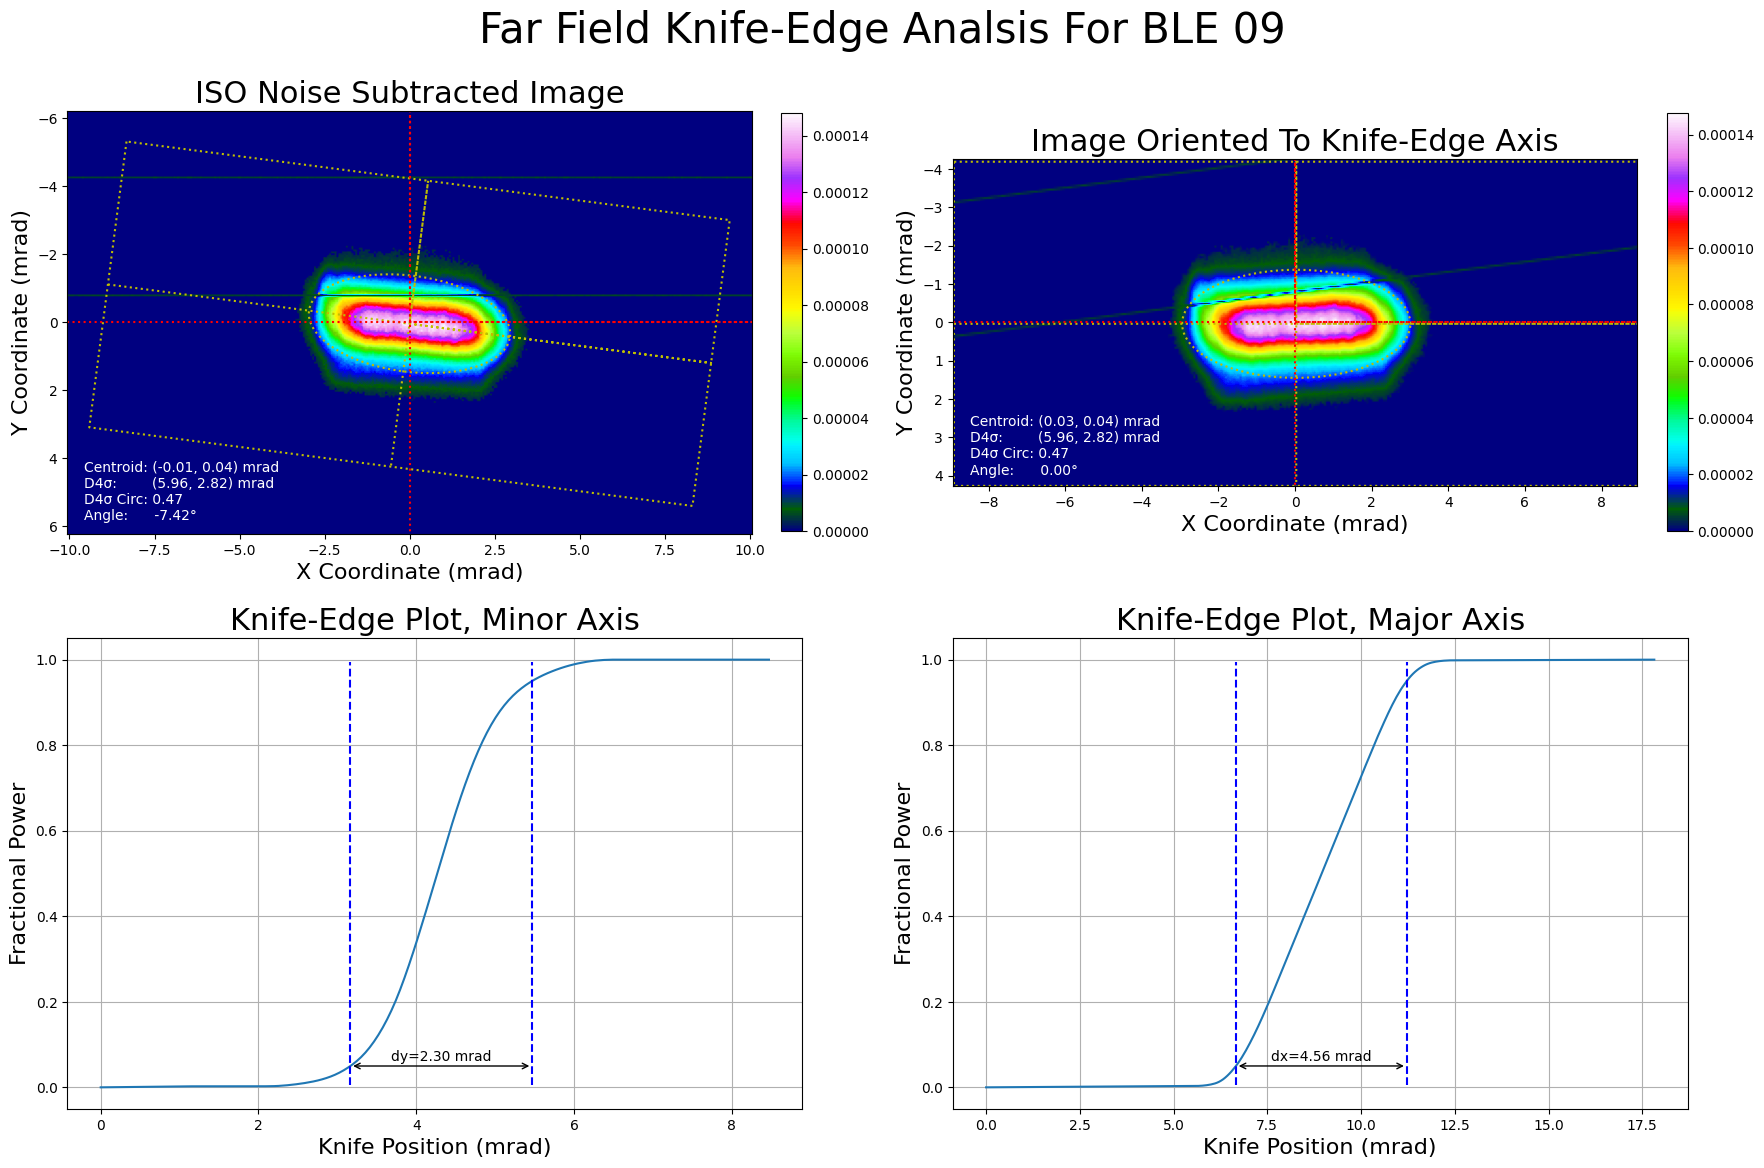

In [3]:
# Parse beam
def crop(img, crop_frac=0.2):
    # Input image
    vv,hh = img.shape
    vd = int(vv * crop_frac)
    hd = int(hh * crop_frac)
    return img[vd:(vv-vd), hd:(hh-hd)]

ff2 = crop(ff)

x, y, dx, dy, phi = lbt.beam_size(ff2)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

ff_nbg = lbt.subtract_corner_background(ff2, iso_noise=False)

ff_c, ffx_c, ffy_c = lbt.crop_image_to_integration_rect(ff_nbg, x, y, dx, dy, phi)

flen = 80 # mm
pixel_size=4.4 # um
# lbt.plot_image_analysis(ff_c, pixel_size=pixel_size/flen, units='mrad',title='Knife-Edge Analsis For %s' % title)
lbt.plot_knife_edge_analysis(ff_c, pixel_size=pixel_size/flen, units='mrad',title='Far Field Knife-Edge Analsis For %s' % title)

# Crop And Center The Near Field
---
Repeat the same steps for near field image.

`nf_c` is our new near field array.

The center of the beam ellipse is at (839, 612)
The ellipse diameter (closest to horizontal) is 310 pixels
The ellipse diameter (closest to   vertical) is 836 pixels
The ellipse is rotated -0° ccw from the horizontal


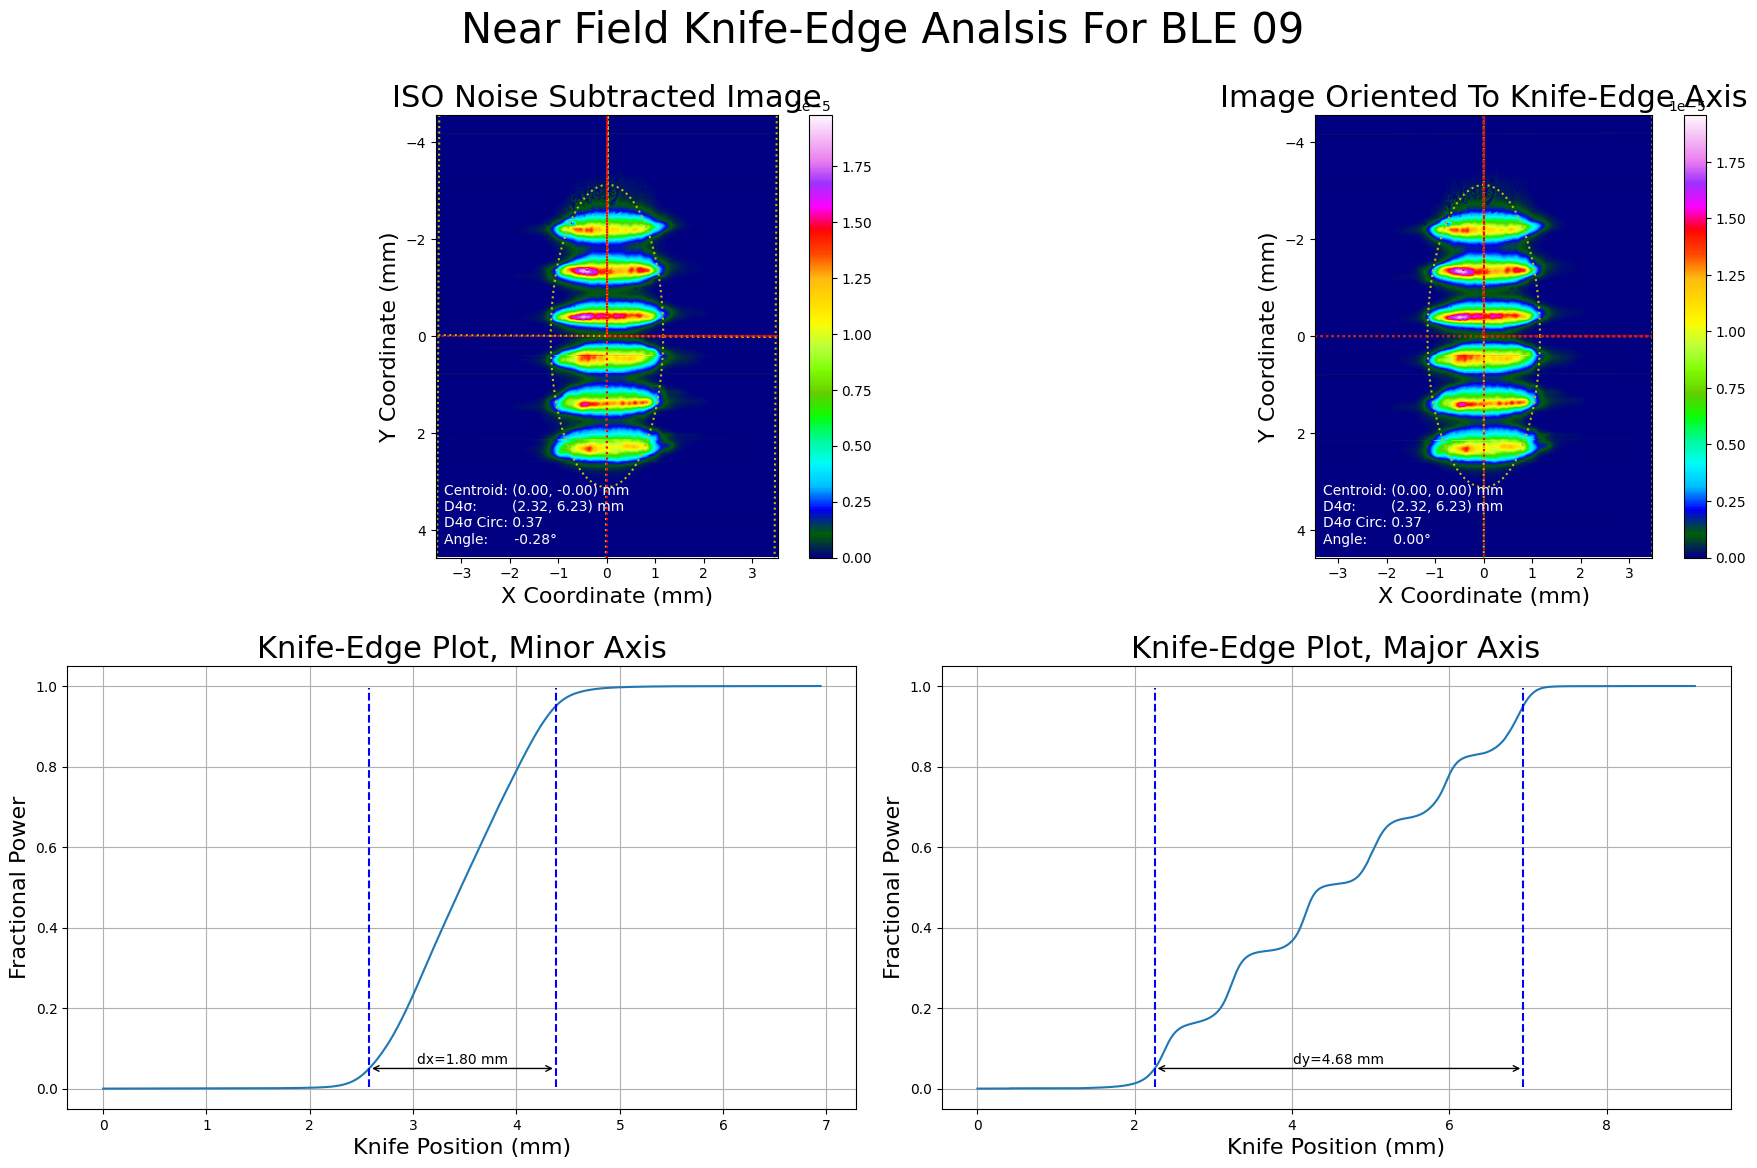

In [4]:
# Parse beam
x, y, dx, dy, phi = lbt.beam_size(nf)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

nf_nbg = lbt.subtract_corner_background(nf, iso_noise=False)
nf_c, nfx_c, nfy_c = lbt.crop_image_to_integration_rect(nf_nbg, x, y, dx, dy, phi)

pixel_size=4.4
mag = 0.59
lbt.plot_knife_edge_analysis(nf_c, pixel_size=pixel_size/mag/1000, units='mm',title='Near Field Knife-Edge Analsis For %s' % title)

# Generate The Rayfile
---

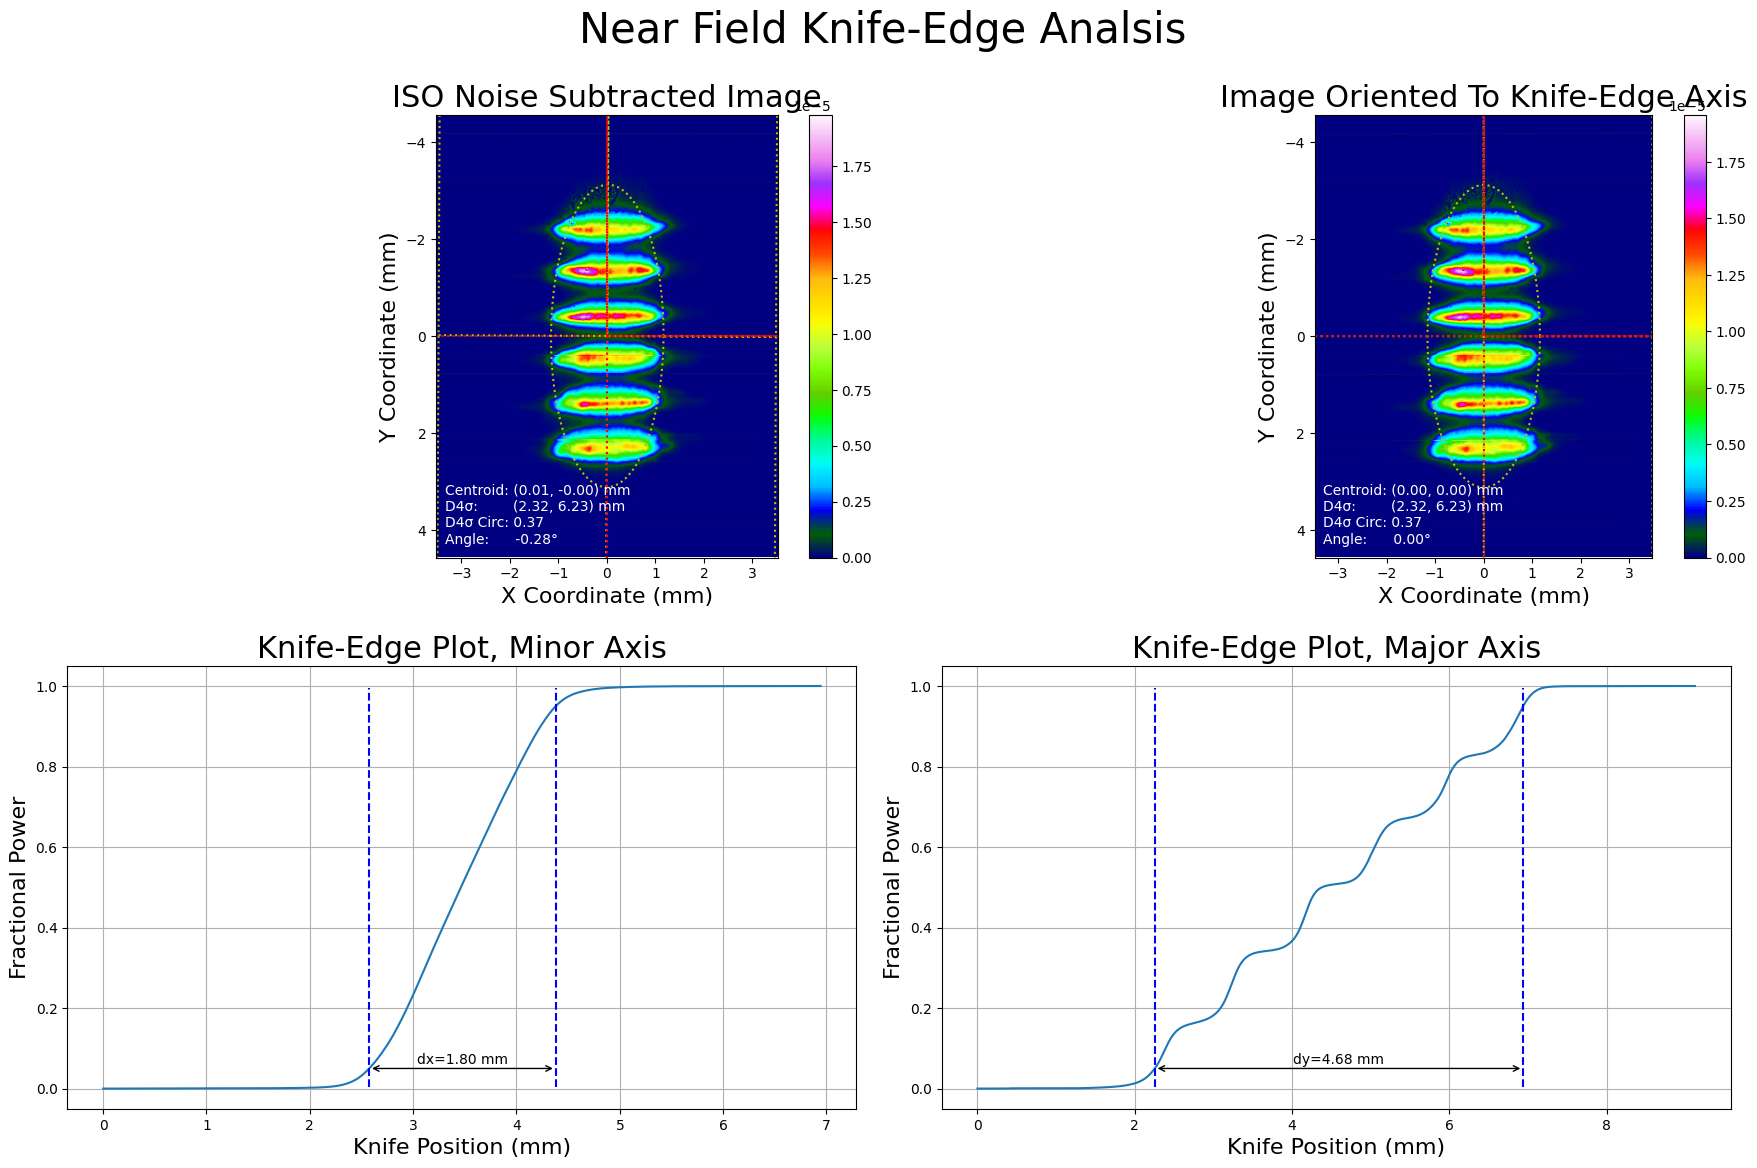

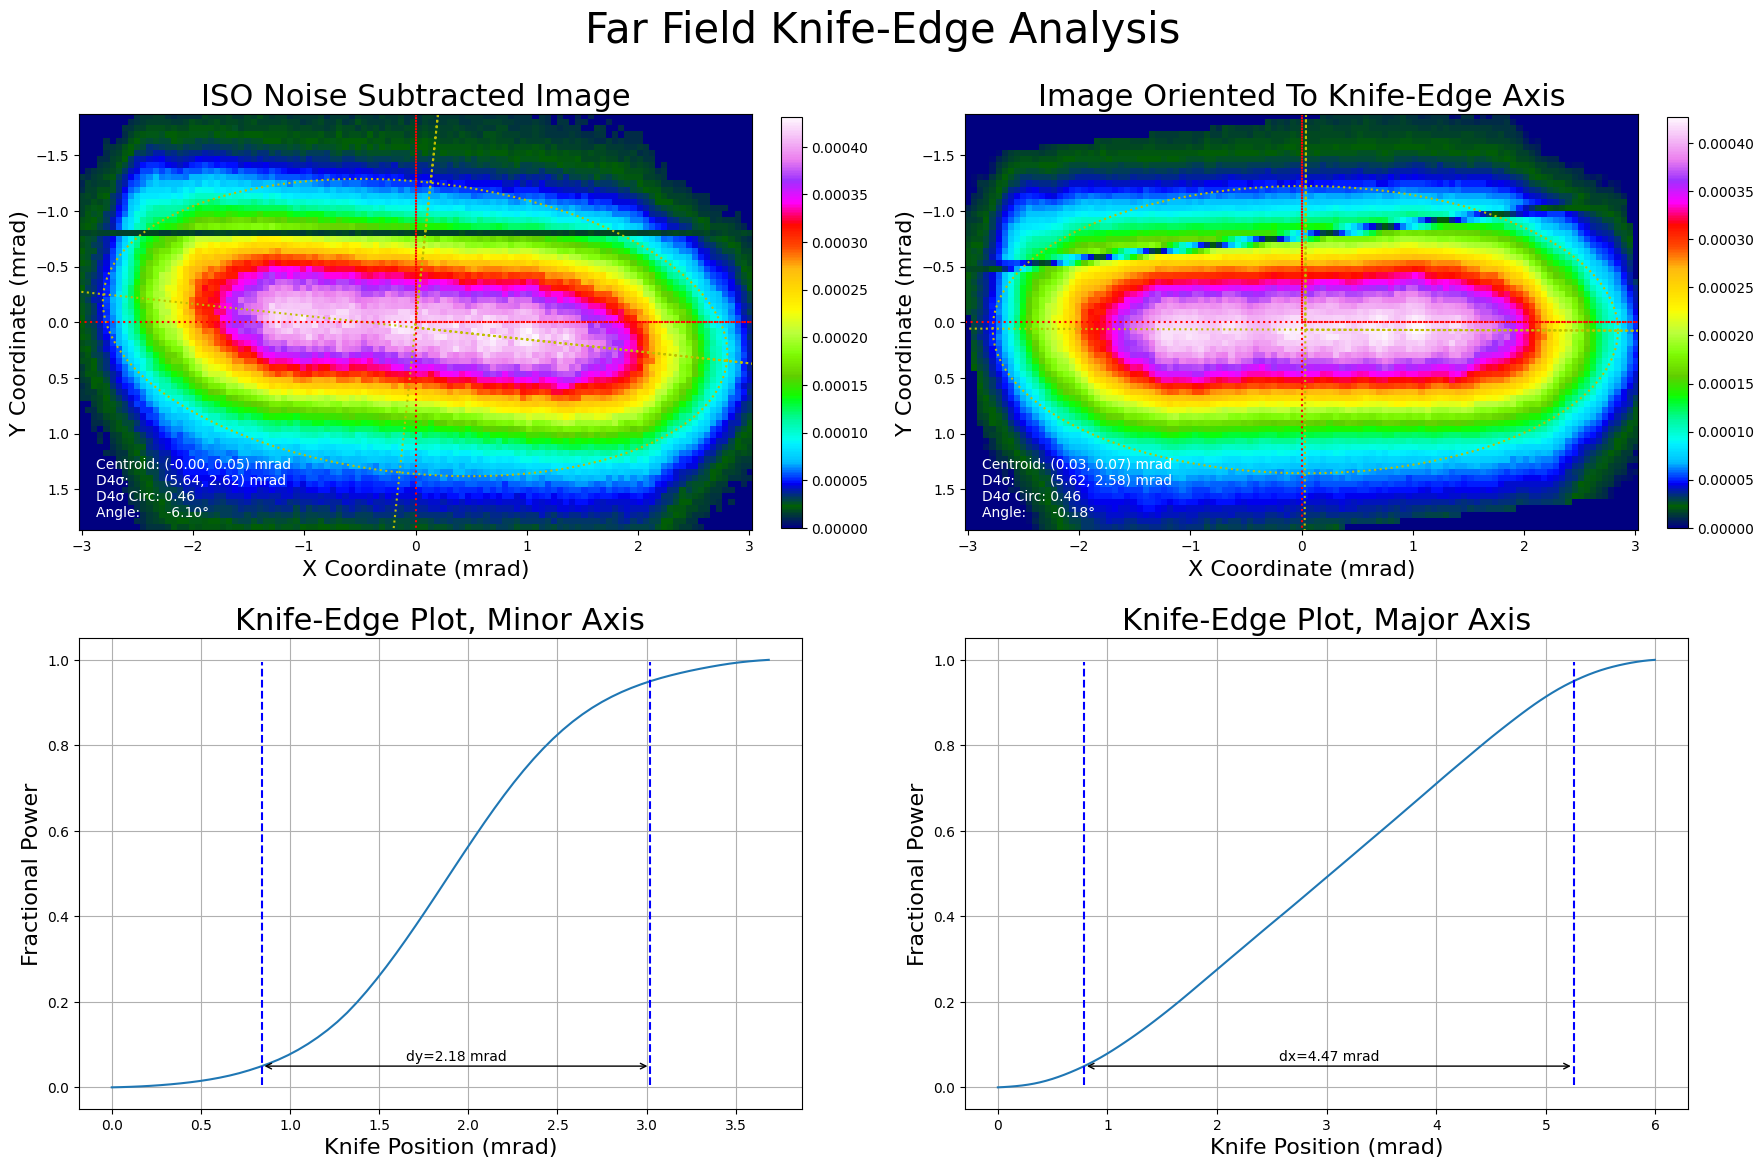

Generating rayfile with 10000 rays, this may take some time...
Rayfile succesfully generated, saved under:
	c:\Users\ryan.robinson\Documents\GitHub\laserbeamtools\docs
		BLE_09_100k.DAT


In [5]:
rg = lbt.Rayfile_gen()
rg.load_nf(nf_c, pixel_size_um=4.4, magnification=0.59)
rg.preview_nf()
rg.load_ff(ff_c, pixel_size_um=4.4, flen_mm=80)
rg.wff.preview_ff()
rg.load_spectrum(spec_x_t, spec_y_t)
rg.generate('BLE_09_100k.DAT', rays = 10000)